In [1]:
# ------------------------------------------------------------------------------ #
# @Author:        F. Paul Spitzner
# @Email:         paul.spitzner@ds.mpg.de
# @Created:       2024-03-23 16:05:20
# @Last Modified: 2024-03-23 16:05:38
# ------------------------------------------------------------------------------ #
# Here we run the bayesian analysis.
# Final plotting is done in a different notebook, as the analysis takes quite
# some time.
# ------------------------------------------------------------------------------ #

%load_ext autoreload
%autoreload 2

import os
import pymc as pm
import nutpie
import numpy as np
import pandas as pd
import arviz as az
import sys

import logging

logging.basicConfig(
    format="%(asctime)s | %(levelname)-8s | %(name)-s | %(funcName)-s | %(message)s",
    level=logging.WARNING,
)
log = logging.getLogger("notebook")
log.setLevel("DEBUG")

extra_path = os.path.abspath("../")
# extra_path = os.path.abspath("/Users/paul/para/5_Archive/information_timescales/repo/_latest/experiment_analysis/")
sys.path.append(extra_path)
log.info(f"project directory: {extra_path}")

from ana import utility as utl
from ana import plot_helper as ph
from ana import bayesian_models as bm

ph.log.setLevel("DEBUG")
utl.log.setLevel("DEBUG")

data_dir = os.path.abspath("../dat")
data_dir = os.path.abspath("/data.nst/lucas/projects/mouse_visual_timescales_predictability/paper_code/experiment_analysis/data")
# data_dir = os.path.abspath("/Users/paul/para/5_Archive/information_timescales/repo/gnode.nosync/experiment_analysis/dat")



2024-05-30 17:27:21,918 | INFO     | notebook | <module> | project directory: /data.nst/lucas/projects/mouse_visual_timescales_predictability/paper_code_repo/experiment_analysis


In [4]:

# load our results from timescale fitting
df = pd.read_hdf(f"{data_dir}/all_units_merged_blocks_with_spont.h5", key="meta_df")

# add metrics from image selectivity etc.
df = utl.load_metrics(
    df.reset_index(),
    data_dir,
    csvs=[
        # we need to combine data from different files, because we use spontaneous and natural movie stimuli
        "brain_observatory_1.1_analysis_metrics.csv",
        "functional_connectivity_analysis_metrics.csv",
    ],
    cols=["on_screen_rf"],
)
df = utl.add_structure_and_hierarchy_scores(df)
df = utl.load_experiments(df, data_dir)

# pymc does not like bools:
log.info(f'invalid metric rows: {df["on_screen_rf"].isna().sum()}')
df["on_screen_rf"] = df["on_screen_rf"].astype("int")

len_before = len(df)
df = df.query("tau_R > 0.0")
df = df.query("tau_double > 0.0 & tau_double < 10.0")

# timescales above 10s are likely an inference problems,
# as we have 600 - 800 seconds of data. cf. https://arxiv.org/abs/2007.03367
len_after = len(df)
log.info(f"removed {len_before - len_after} rows due to unexpected timescales")

# some further preprocessing is done in the model class
# see ana/bayesian_models.py
df

2024-05-29 21:32:16,178 | DEBUG    | its_utility | load_metrics | Loaded columns ['unit_id', 'on_screen_rf'] from /data.nst/lucas/projects/mouse_visual_timescales_predictability/paper_code/experiment_analysis/data/brain_observatory_1.1_analysis_metrics.csv
2024-05-29 21:32:16,450 | DEBUG    | its_utility | load_metrics | Loaded columns ['unit_id', 'on_screen_rf'] from /data.nst/lucas/projects/mouse_visual_timescales_predictability/paper_code/experiment_analysis/data/functional_connectivity_analysis_metrics.csv
2024-05-29 21:32:16,451 | INFO     | its_utility | load_metrics | Column on_screen_rf found in multiple dataframes.
2024-05-29 21:32:16,453 | DEBUG    | its_utility | load_metrics | Matched 6368 rows from meta_df in /data.nst/lucas/projects/mouse_visual_timescales_predictability/paper_code/experiment_analysis/data/brain_observatory_1.1_analysis_metrics.csv
2024-05-29 21:32:19,948 | DEBUG    | its_utility | load_metrics | Matched 11581 rows from meta_df in /data.nst/lucas/projects

,unit_id,stimulus,session,block,ecephys_structure_acronym,invalid_spiketimes_check,recording_length,firing_rate,filepath,num_spikes,...,tau_R,tau_single,tau_double,tau_R_details,tau_single_details,tau_double_details,on_screen_rf,structure_name,hierarchy_score,session_type
0,950911932,natural_movie_three,715093703,merged_3.0_and_6.0,VISam,SUCCESS,1078.491211,8.025100,/project.nst/neuroscience-raw/Allen/visual_cod...,8655,...,0.058510,0.000054,0.748946,"{'firing_rate': 8.012090922999178, 'firing_rat...","{'tau': 5.404084198337884e-05, 'mre': 6.575654...","{'tau': 0.7489462162647652, 'mre': 0.993346188...",0,AM,0.441,brain_observatory_1.1
1,950911986,natural_movie_three,715093703,merged_3.0_and_6.0,VISam,SUCCESS,1079.203369,3.647135,/project.nst/neuroscience-raw/Allen/visual_cod...,3936,...,0.088701,2.302634,1.874703,"{'firing_rate': 3.6471291367256455, 'firing_ra...","{'tau': 2.3026338728859774, 'mre': 0.997830929...","{'tau': 1.874703126979266, 'mre': 0.9973364645...",0,AM,0.441,brain_observatory_1.1
2,950912164,natural_movie_three,715093703,merged_3.0_and_6.0,VISam,SUCCESS,1077.872803,8.500075,/project.nst/neuroscience-raw/Allen/visual_cod...,9162,...,0.059416,1.026283,1.026284,"{'firing_rate': 8.475008697669026, 'firing_rat...","{'tau': 1.0262833654998276, 'mre': 0.995139899...","{'tau': 1.0262836602024297, 'mre': 0.995139901...",1,AM,0.441,brain_observatory_1.1
3,950912190,natural_movie_three,715093703,merged_3.0_and_6.0,VISam,SUCCESS,1075.171875,4.399297,/project.nst/neuroscience-raw/Allen/visual_cod...,4730,...,0.116100,1.564297,1.363502,"{'firing_rate': 4.395563512916502, 'firing_rat...","{'tau': 1.5642971952849982, 'mre': 0.996808779...","{'tau': 1.363502294341311, 'mre': 0.9963396881...",1,AM,0.441,brain_observatory_1.1
4,950912214,natural_movie_three,715093703,merged_3.0_and_6.0,VISam,SUCCESS,1073.492432,5.326540,/project.nst/neuroscience-raw/Allen/visual_cod...,5718,...,0.064748,0.605686,0.377801,"{'firing_rate': 5.317211538013684, 'firing_rat...","{'tau': 0.6056864214354767, 'mre': 0.991778883...","{'tau': 0.37780093267583975, 'mre': 0.98685270...",1,AM,0.441,brain_observatory_1.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17944,950942400,spontaneous,771160300,null,VISal,SUCCESS,1797.115234,0.377828,/project.nst/neuroscience-raw/Allen/visual_cod...,679,...,0.049446,0.257024,0.217925,"{'firing_rate': 0.36583331347267567, 'firing_r...","{'tau': 0.25702383931940154, 'mre': 0.98073454...","{'tau': 0.2179251442600049, 'mre': 0.977317546...",0,AL,0.152,functional_connectivity
17945,950944614,spontaneous,771160300,null,VISal,SUCCESS,1792.901855,0.377600,/project.nst/neuroscience-raw/Allen/visual_cod...,677,...,0.042486,0.439570,0.057439,"{'firing_rate': 0.38629086027452963, 'firing_r...","{'tau': 0.4395698459887982, 'mre': 0.988689691...","{'tau': 0.05743850656844875, 'mre': 0.91663161...",0,AL,0.152,functional_connectivity
17946,950943984,spontaneous,771160300,null,VISal,SUCCESS,1773.977051,0.135289,/project.nst/neuroscience-raw/Allen/visual_cod...,240,...,0.043392,0.170987,0.170986,"{'firing_rate': 0.13628681470096451, 'firing_r...","{'tau': 0.1709865057191234, 'mre': 0.971181338...","{'tau': 0.17098641292634262, 'mre': 0.97118132...",0,AL,0.152,functional_connectivity
17947,950942680,spontaneous,771160300,null,VISal,SUCCESS,1801.591797,12.195324,/project.nst/neuroscience-raw/Allen/visual_cod...,21971,...,0.008184,0.081918,0.068260,"{'firing_rate': 12.154834329411557, 'firing_ra...","{'tau': 0.08191797577480081, 'mre': 0.94078874...","{'tau': 0.06826005692776223, 'mre': 0.92936912...",1,AL,0.152,functional_connectivity


            mu_intercept ~ Normal(0, 1)
         sigma_intercept ~ HalfCauchy(0, 1)
                mu_slope ~ Normal(0, 1)
             sigma_slope ~ HalfCauchy(0, 1)
session_intercept_scaled ~ Normal(0, 1)
    session_slope_scaled ~ Normal(0, 1)
                 b_os_rf ~ Normal(0, 1)
                b_log_fr ~ Normal(0, 1)
                 epsilon ~ HalfCauchy(0, 10)
                   alpha ~ Normal(0, 1)
       session_intercept ~ Deterministic(f(session_intercept_scaled, mu_intercept, sigma_intercept))
           session_slope ~ Deterministic(f(session_slope_scaled, mu_slope, sigma_slope))
              likelihood ~ SkewNormal(f(b_log_fr, b_os_rf, session_intercept_scaled, mu_intercept, session_slope_scaled, mu_slope, sigma_intercept, sigma_slope), epsilon, alpha)


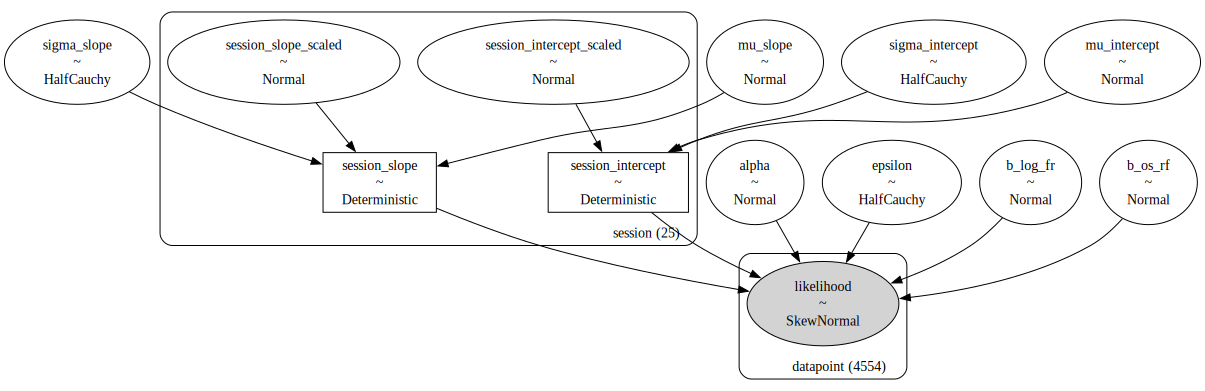

In [42]:
lm_tau_R = bm.LinearMedianModel(
    df=df.query(
        "stimulus == 'natural_movie_one_more_repeats'  & "
        + "structure_name in ['V1', 'LM', 'RL', 'AL', 'PM', 'AM']"
    ),
    measure="tau_R",
    noncentered=True,
)
print(lm_tau_R.str_repr())
pm.model_to_graphviz(lm_tau_R)

     mu_intercept ~ Normal(0, 1)
  sigma_intercept ~ HalfCauchy(0, 0.1)
     mu_hc_offset ~ Normal(0, 1)
  sigma_hc_offset ~ HalfCauchy(0, 1)
     mu_th_offset ~ Normal(0, 1)
  sigma_th_offset ~ HalfCauchy(0, 1)
session_intercept ~ Normal(mu_intercept, sigma_intercept)
session_hc_offset ~ Normal(mu_hc_offset, sigma_hc_offset)
session_th_offset ~ Normal(mu_th_offset, sigma_th_offset)
 global_intercept ~ Normal(0, 1)
          b_os_rf ~ Normal(0, 1)
         b_log_fr ~ Normal(0, 1)
          epsilon ~ HalfCauchy(0, 10)
       likelihood ~ Normal(f(b_log_fr, b_os_rf, session_th_offset, session_hc_offset, session_intercept, global_intercept), epsilon)


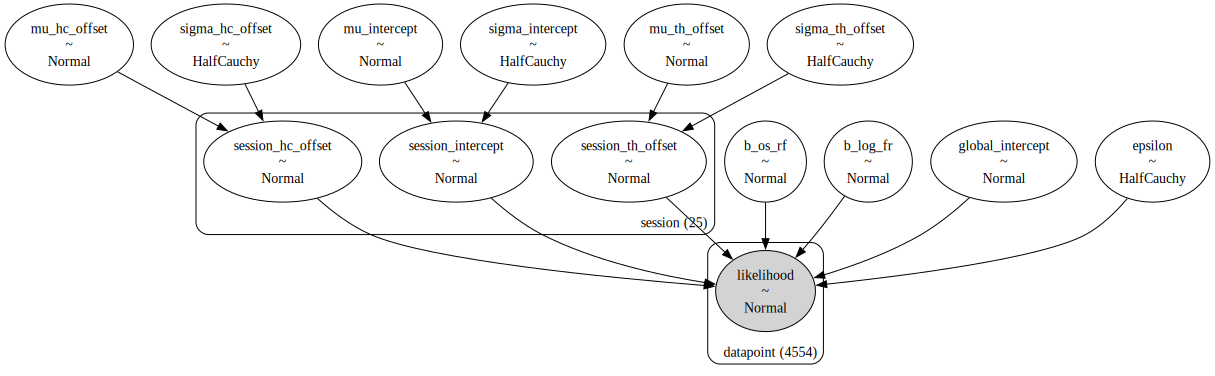

In [76]:
sgm_R_tot = bm.StructureGroupModel(
    df=df.query(
        "stimulus == 'natural_movie_one_more_repeats'  & "
        + "structure_name in ['V1', 'LM', 'RL', 'AL', 'PM', 'AM']"
    ),
    measure="R_tot",
    noncentered=False,
)
print(sgm_R_tot.str_repr())
pm.model_to_graphviz(sgm_R_tot)

# Example analysis for linear model and measure `R_tot`

In [43]:
lm_tau_R = bm.LinearMedianModel(
    df=df.query(
        "stimulus == 'natural_movie_one_more_repeats'  & "
        + "structure_name in ['V1', 'LM', 'RL', 'AL', 'PM', 'AM']"
    ),
    measure="tau_R",
    noncentered=True,
)
with lm_tau_R:
    idata = pm.sample(
        nuts_sampler="nutpie",
        draws=3000,
        tune=2000,
        random_seed=42,
        target_accept=0.95,
    )

In [44]:
with lm_tau_R:
    pm.compute_log_likelihood(idata)
    az.loo(idata, pointwise=True)

Output()

In [45]:
az.loo(idata, pointwise=True)

Computed from 12000 posterior samples and 4554 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -6109.97    66.21
p_loo       39.83        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     4554  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [46]:
with lm_tau_R:
    idata.extend(pm.sample_prior_predictive(random_seed=42))
    idata.extend(pm.sample_posterior_predictive(trace=idata, random_seed=42))

Sampling: [alpha, b_log_fr, b_os_rf, epsilon, likelihood, mu_intercept, mu_slope, session_intercept_scaled, session_slope_scaled, sigma_intercept, sigma_slope]
2024-05-29 17:57:06,742 | INFO     | pymc.sampling.forward | sample_prior_predictive | Sampling: [alpha, b_log_fr, b_os_rf, epsilon, likelihood, mu_intercept, mu_slope, session_intercept_scaled, session_slope_scaled, sigma_intercept, sigma_slope]
Sampling: [likelihood]
2024-05-29 17:57:07,156 | INFO     | pymc.sampling.forward | sample_posterior_predictive | Sampling: [likelihood]


Output()

In [67]:
idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

Warmup iterations saved (warmup_*).

In [14]:
az.summary(
    idata,
    var_names=[
        "b_log_fr",
        "b_os_rf",
        "epsilon",
        "mu_intercept",
        "mu_slope",
        "sigma_intercept",
        "sigma_slope",
        "session_slope",
    ],
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b_log_fr,-0.875,0.081,-1.018,-0.711,0.001,0.001,11750.0,8517.0,1.0
b_os_rf,-0.441,0.065,-0.562,-0.319,0.001,0.000,9035.0,8555.0,1.0
epsilon,1.335,0.022,1.294,1.378,0.000,0.000,5589.0,7295.0,1.0
mu_intercept,2.528,0.110,2.316,2.729,0.002,0.001,3152.0,4399.0,1.0
mu_slope,0.537,0.115,0.320,0.754,0.002,0.001,3963.0,5705.0,1.0
sigma_intercept,0.338,0.071,0.211,0.471,0.001,0.001,3532.0,5236.0,1.0
sigma_slope,0.424,0.099,0.247,0.611,0.002,0.001,3610.0,5216.0,1.0
session_slope[0],0.476,0.278,-0.068,0.981,0.003,0.002,10993.0,9185.0,1.0
session_slope[1],0.697,0.243,0.226,1.138,0.002,0.002,14115.0,9555.0,1.0
session_slope[2],0.374,0.254,-0.117,0.846,0.002,0.002,12636.0,9265.0,1.0


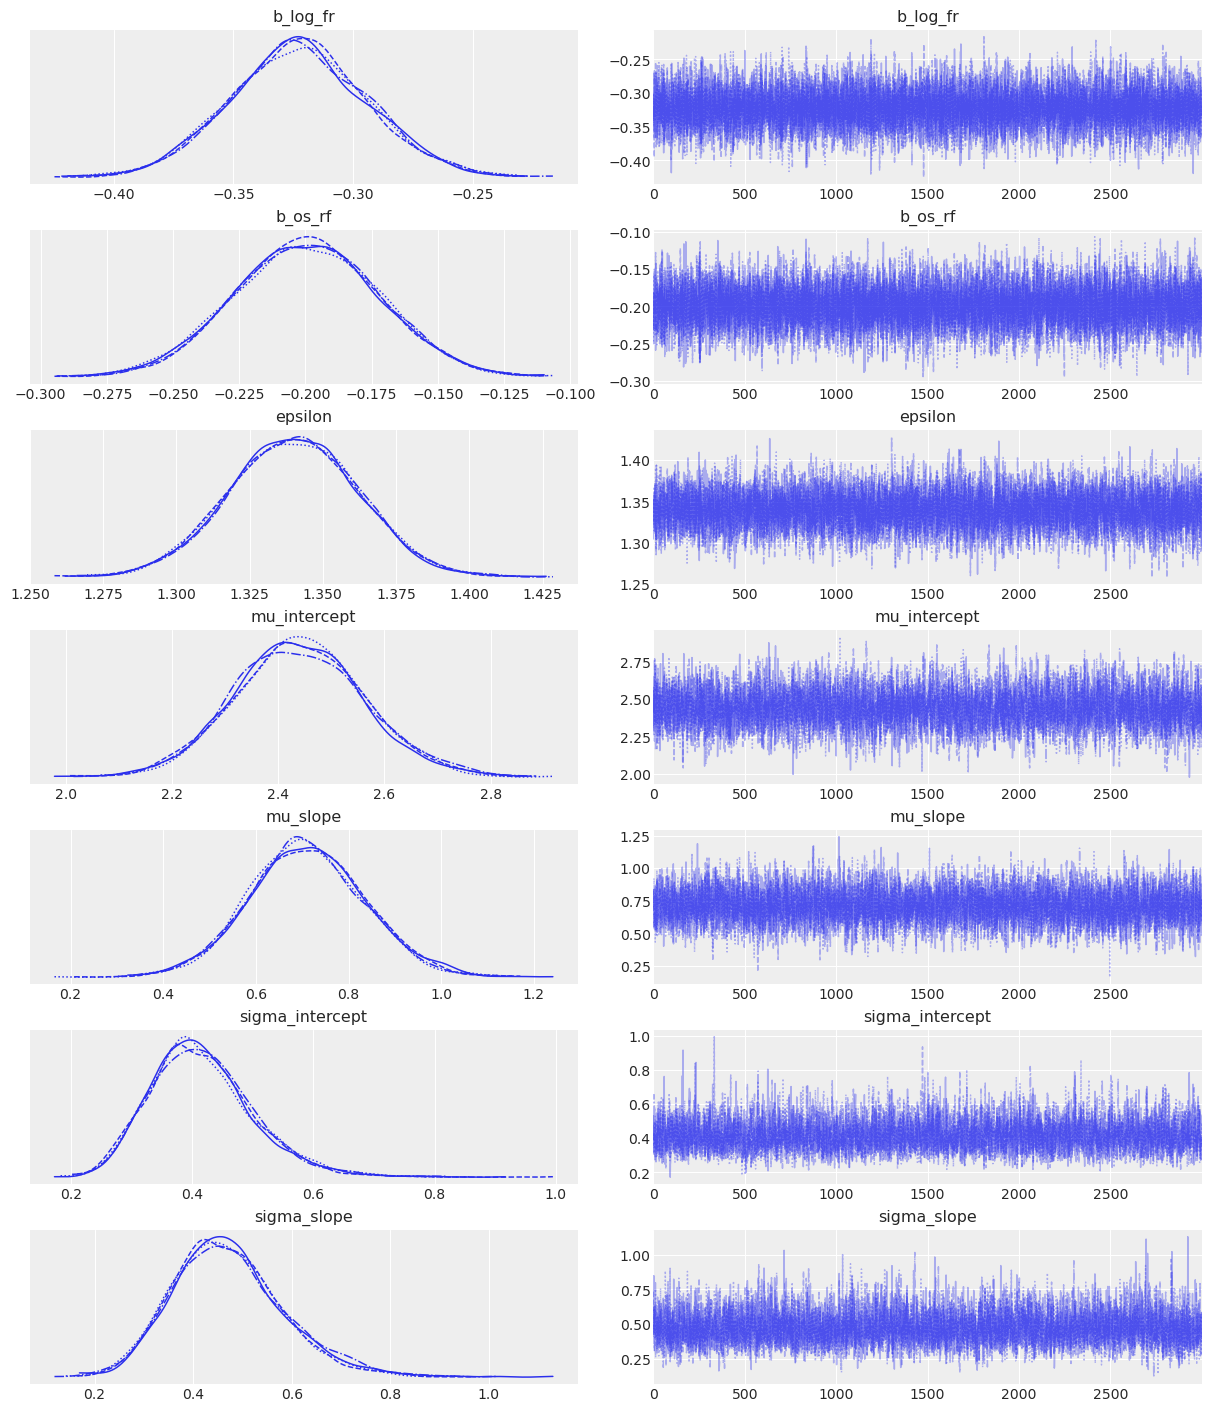

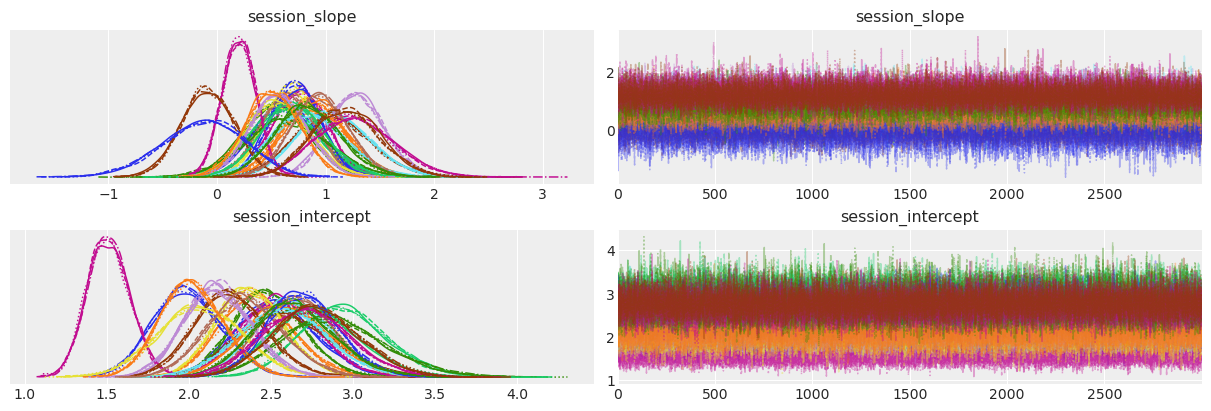

In [47]:
az.style.use("arviz-darkgrid")
# blue lines represent chains
az.plot_trace(
    idata,
    var_names=[
        "b_log_fr",
        "b_os_rf",
        "epsilon",
        "mu_intercept",
        "mu_slope",
        "sigma_intercept",
        "sigma_slope",
    ],
    legend=False,
);
# color varies across sessions
az.plot_trace(
    idata,
    var_names=[
        "session_slope",
        "session_intercept",
    ],
    legend=False,
);

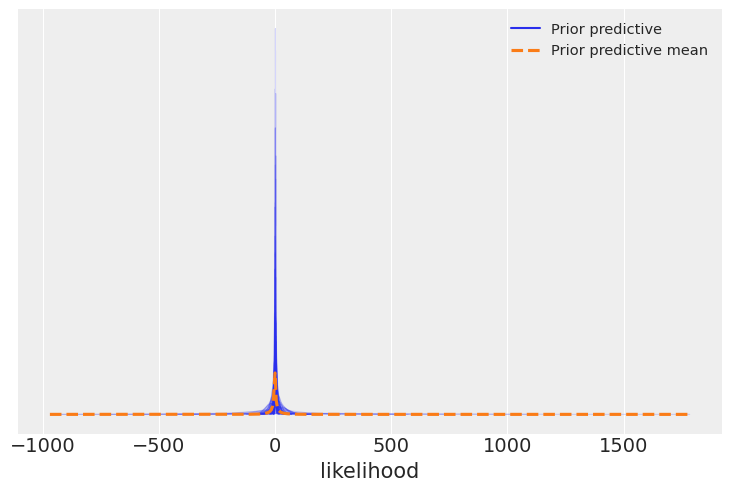

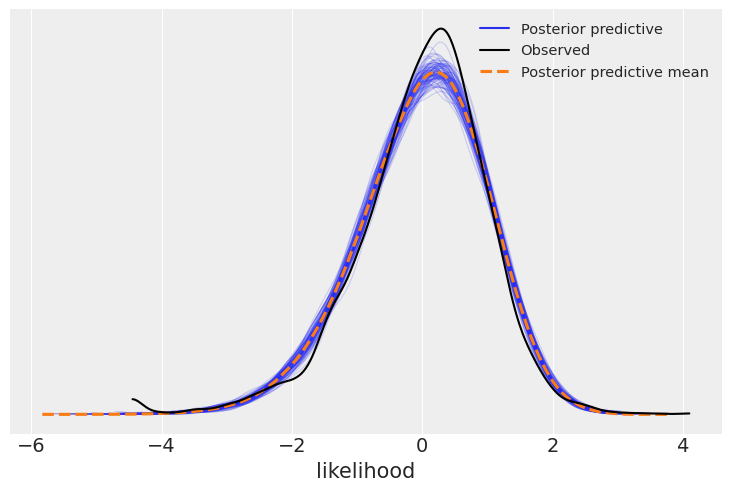

In [17]:
az.plot_ppc(
    idata,
    num_pp_samples=100,
    kind="kde",
    group="prior",
);
az.plot_ppc(
    idata,
    num_pp_samples=100,
    kind="kde",
    group="posterior",
);

# Generate traces for model comparison

In [14]:
from itertools import product


# define models
models = ["lmm", "sgm"]
stimuli = df["stimulus"].unique()
measures = ["R_tot", "tau_R", "tau_double"]
areas = ["cortex"] # only need model for cortex
# areas = ["allareas", "cortex"]
combinations = list(product(areas, models, measures, stimuli))
log.info(f"{combinations=}")

# ~1h on M1 mac
for area, model_name, measure, stim, in combinations:

    if area == "allareas" and model_name == "lmm":
        # linear model needs hierarchy score values, which dont exist for thalamus.
        # for model comparison, we only use models fitted on cortex.
        continue

    log.info(f"running: {model_name} {stim} {measure} {area}")

    if area == "allareas":
        this_df = df
    elif area == "cortex":
        this_df = df.query(f"structure_name in ['V1', 'LM', 'RL', 'AL', 'PM', 'AM']")
    else:
        raise ValueError(f"unknown area: {area}")

    this_df = this_df.query(f"stimulus == '{stim}'")

    log.info(f"using df for {stim} with {len(this_df)} rows")
    if model_name == "lmm":
        model = bm.LinearMedianModel(
            this_df,
            measure,
            noncentered=True,
        )
    elif model_name == "sgm":
        model = bm.StructureGroupModel(
            this_df,
            measure,
            noncentered=True,
        )
    else:
        raise ValueError(f"unknown model: {model_name}")

    with model:
        idata = pm.sample(
            nuts_sampler="nutpie",
            draws=3000,
            tune=2000,
            random_seed=42,
            target_accept=0.95,
        )

        log.info(f"running ppc: {model_name}")
        idata.extend(pm.sample_prior_predictive(random_seed=42))
        idata.extend(pm.sample_posterior_predictive(trace=idata, random_seed=42))

        log.info(f"computing likeliehood: {model_name}")
        idata.extend(pm.compute_log_likelihood(idata))

        log.info(f"saving: {model_name}")
        idata.to_netcdf(
            f"{data_dir}/bayes_{area}_{model_name}_{measure}_{stim}.nc"
        )  # ~ 1.8GB each

2024-05-29 21:50:33,730 | INFO     | notebook | <module> | combinations=[('cortex', 'lmm', 'R_tot', 'natural_movie_three'), ('cortex', 'lmm', 'R_tot', 'natural_movie_one_more_repeats'), ('cortex', 'lmm', 'R_tot', 'spontaneous'), ('cortex', 'lmm', 'tau_R', 'natural_movie_three'), ('cortex', 'lmm', 'tau_R', 'natural_movie_one_more_repeats'), ('cortex', 'lmm', 'tau_R', 'spontaneous'), ('cortex', 'lmm', 'tau_double', 'natural_movie_three'), ('cortex', 'lmm', 'tau_double', 'natural_movie_one_more_repeats'), ('cortex', 'lmm', 'tau_double', 'spontaneous'), ('cortex', 'sgm', 'R_tot', 'natural_movie_three'), ('cortex', 'sgm', 'R_tot', 'natural_movie_one_more_repeats'), ('cortex', 'sgm', 'R_tot', 'spontaneous'), ('cortex', 'sgm', 'tau_R', 'natural_movie_three'), ('cortex', 'sgm', 'tau_R', 'natural_movie_one_more_repeats'), ('cortex', 'sgm', 'tau_R', 'spontaneous'), ('cortex', 'sgm', 'tau_double', 'natural_movie_three'), ('cortex', 'sgm', 'tau_double', 'natural_movie_one_more_repeats'), ('cortex'

2024-05-29 21:52:53,434 | INFO     | notebook | <module> | running ppc: sgm
Sampling: [alpha, b_log_fr, b_os_rf, epsilon, global_intercept, likelihood, mu_hc_offset, mu_intercept, mu_th_offset, session_hc_offset_scaled, session_intercept_scaled, session_th_offset_scaled, sigma_hc_offset, sigma_intercept, sigma_th_offset]
2024-05-29 21:52:54,195 | INFO     | pymc.sampling.forward | sample_prior_predictive | Sampling: [alpha, b_log_fr, b_os_rf, epsilon, global_intercept, likelihood, mu_hc_offset, mu_intercept, mu_th_offset, session_hc_offset_scaled, session_intercept_scaled, session_th_offset_scaled, sigma_hc_offset, sigma_intercept, sigma_th_offset]
Sampling: [likelihood]
2024-05-29 21:52:54,606 | INFO     | pymc.sampling.forward | sample_posterior_predictive | Sampling: [likelihood]


Output()

2024-05-29 21:52:58,730 | INFO     | notebook | <module> | computing likeliehood: sgm


Output()

2024-05-29 21:53:02,451 | INFO     | notebook | <module> | saving: sgm


BlockingIOError: [Errno 11] Unable to synchronously create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable')

In [6]:
from itertools import product  

# define models

models = ["lmm", "sgm"]
stimuli = df["stimulus"].unique()
measures = ["R_tot", "tau_R", "tau_double"]
areas = ["cortex"]  # only need model for cortex
# areas = ["allareas", "cortex"]
combinations = list(product(areas, models, measures, stimuli))
log.info(f"{combinations=}")

2024-05-29 21:32:43,241 | INFO     | notebook | <module> | combinations=[('cortex', 'lmm', 'R_tot', 'natural_movie_three'), ('cortex', 'lmm', 'R_tot', 'natural_movie_one_more_repeats'), ('cortex', 'lmm', 'R_tot', 'spontaneous'), ('cortex', 'lmm', 'tau_R', 'natural_movie_three'), ('cortex', 'lmm', 'tau_R', 'natural_movie_one_more_repeats'), ('cortex', 'lmm', 'tau_R', 'spontaneous'), ('cortex', 'lmm', 'tau_double', 'natural_movie_three'), ('cortex', 'lmm', 'tau_double', 'natural_movie_one_more_repeats'), ('cortex', 'lmm', 'tau_double', 'spontaneous'), ('cortex', 'sgm', 'R_tot', 'natural_movie_three'), ('cortex', 'sgm', 'R_tot', 'natural_movie_one_more_repeats'), ('cortex', 'sgm', 'R_tot', 'spontaneous'), ('cortex', 'sgm', 'tau_R', 'natural_movie_three'), ('cortex', 'sgm', 'tau_R', 'natural_movie_one_more_repeats'), ('cortex', 'sgm', 'tau_R', 'spontaneous'), ('cortex', 'sgm', 'tau_double', 'natural_movie_three'), ('cortex', 'sgm', 'tau_double', 'natural_movie_one_more_repeats'), ('cortex'

In [24]:
for area, model_name, measure, stim, in combinations:
    try:
        idata = az.from_netcdf(f"{data_dir}/bayes_{area}_{model_name}_{measure}_{stim}.nc")
    except FileNotFoundError:
        continue

    summary = az.summary(idata)
    r_hat = summary.r_hat
    num_divergences = np.sum(idata.sample_stats.diverging.values)
    print(
        f"{area} {model_name} {measure} {stim}: "
        + f"{'No divergences' if num_divergences == 0 else f'{num_divergences} divergences !!!'} "
        + (f"(r_hat: {r_hat.max():.1f})" if r_hat.max() < 1.1 else f"r_hat: {r_hat.max():.1f} !!!")
    )

cortex sgm tau_R natural_movie_one_more_repeats: No divergences (r_hat: 1.0)
cortex sgm tau_R spontaneous: No divergences (r_hat: 1.0)
cortex sgm tau_double natural_movie_three: No divergences (r_hat: 1.0)
cortex sgm tau_double natural_movie_one_more_repeats: No divergences (r_hat: 1.0)
cortex sgm tau_double spontaneous: No divergences (r_hat: 1.0)


# Reviewer Suggestion

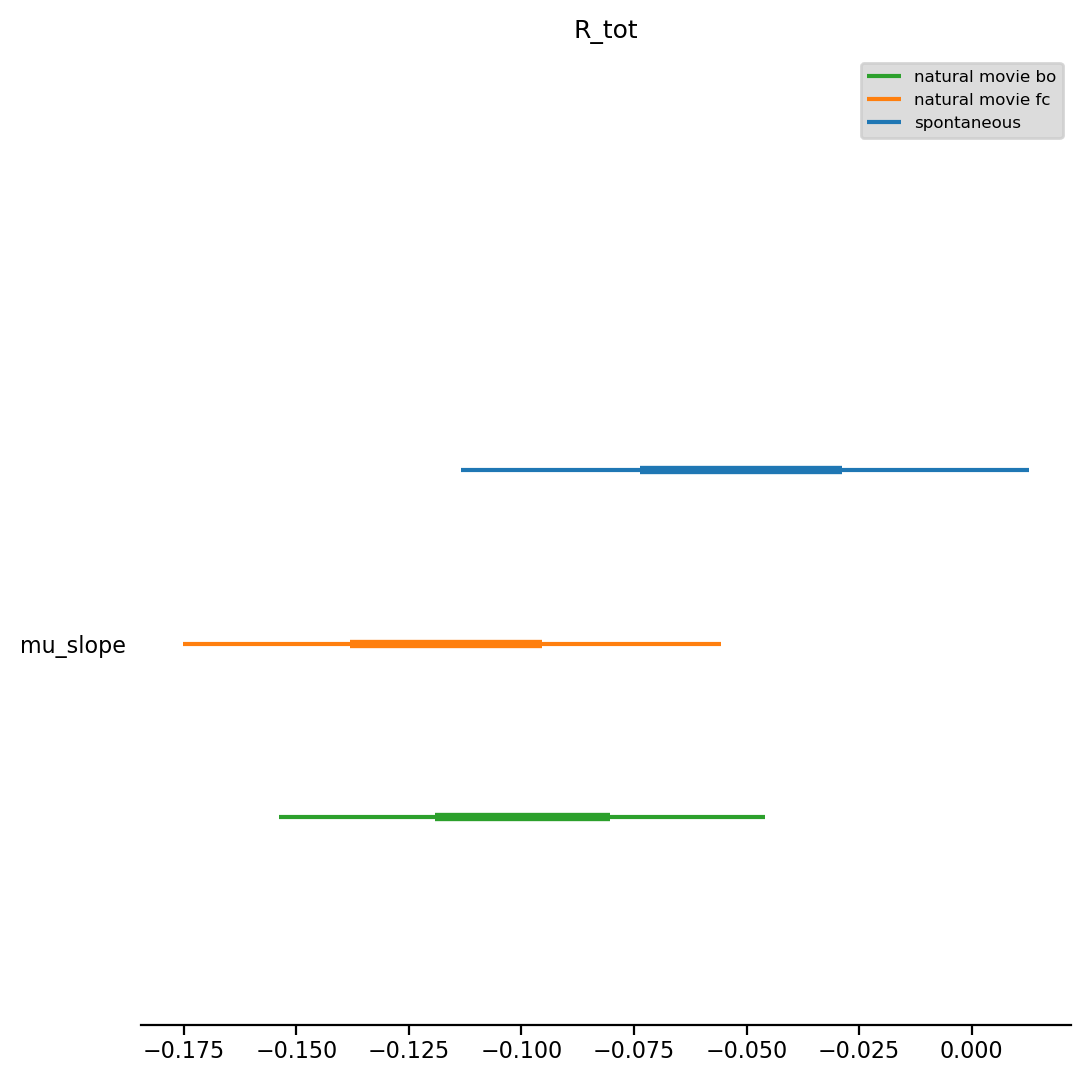

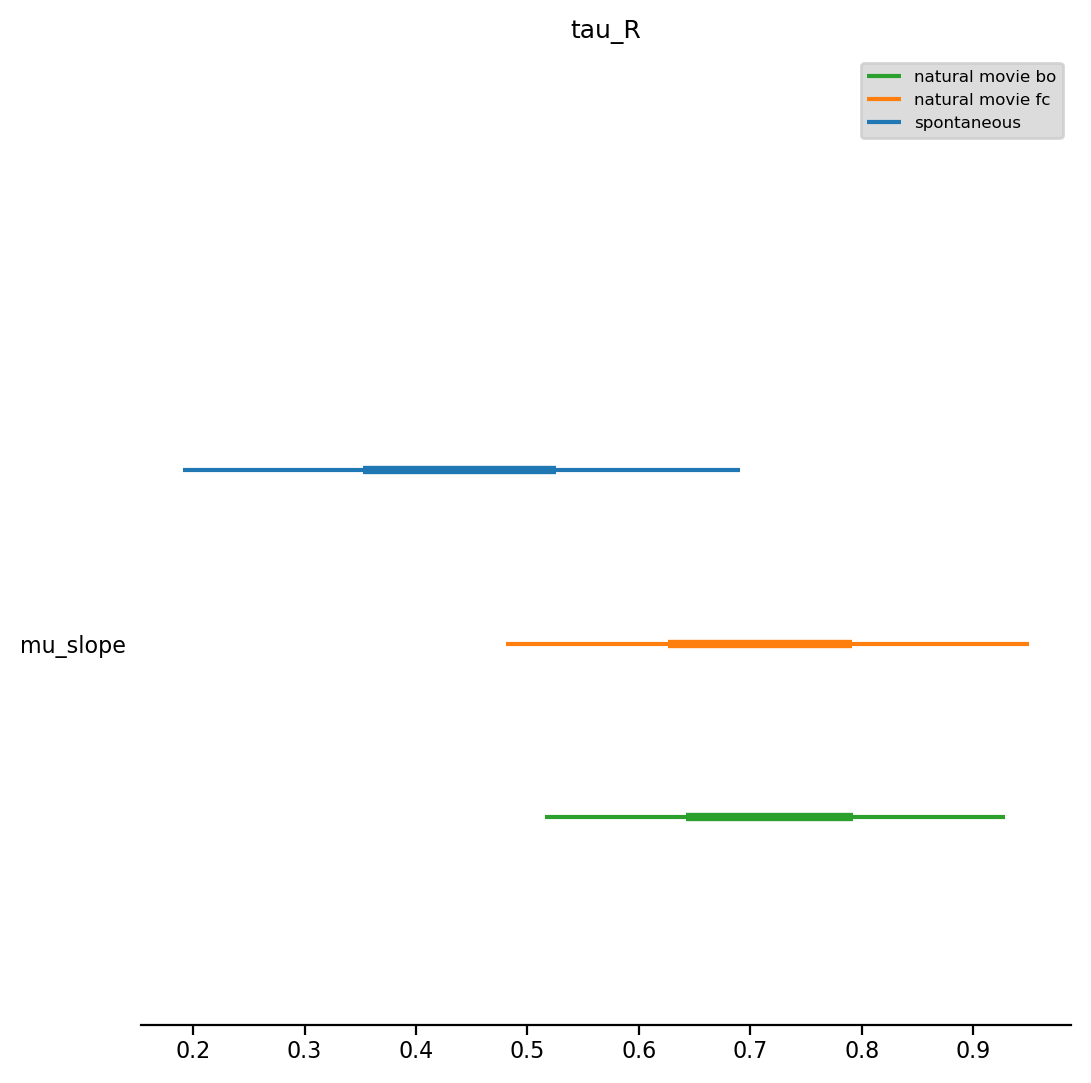

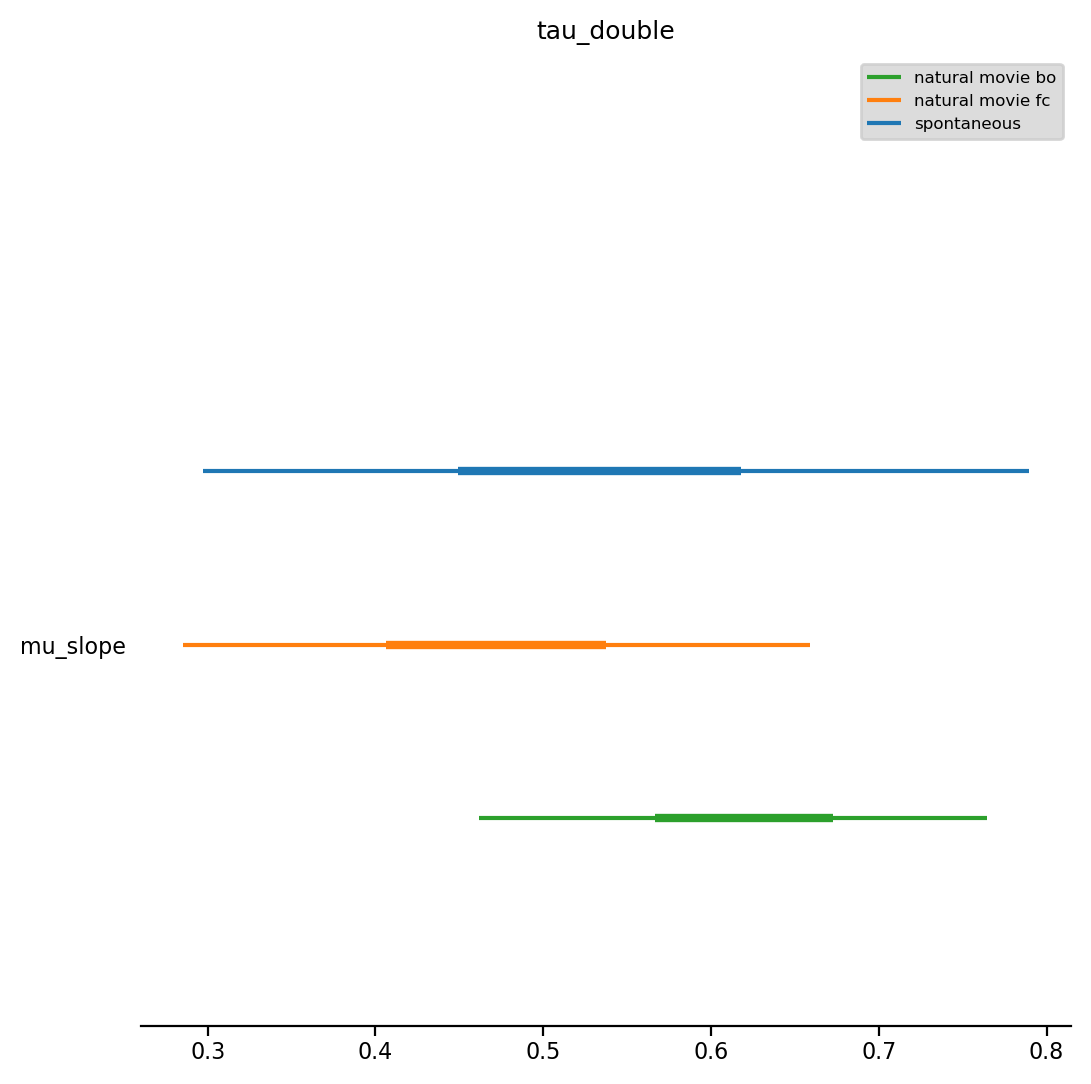

In [26]:
for obs in ["R_tot", "tau_R", "tau_double"]:
    idata_spont = az.from_netcdf(f"{data_dir}/bayes_cortex_lmm_{obs}_spontaneous.nc")
    idata_nat_mov_fc = az.from_netcdf(f"{data_dir}/bayes_cortex_lmm_{obs}_natural_movie_one_more_repeats.nc")
    idata_nat_mov_bo = az.from_netcdf(f"{data_dir}/bayes_cortex_lmm_{obs}_natural_movie_three.nc")
    ax = az.plot_forest(
        [
            idata_spont,
            idata_nat_mov_fc,
            idata_nat_mov_bo,
        ],
        model_names=["spontaneous",  "natural movie fc", "natural movie bo"],
        var_names=["mu_slope"],
        combined=True, # combines chains
        combine_dims=set(["draw", "session"]),
    )
    ax[0].set_title(obs)

In [12]:
%load_ext watermark
%watermark -v --iversions --packages nutpie,pymc,arviz

Python implementation: CPython
Python version       : 3.11.9
IPython version      : 8.22.2

nutpie: 0.10.0
pymc  : 5.14.0
arviz : 0.18.0

numpy         : 1.24.4
sys           : 3.11.9 | packaged by conda-forge | (main, Apr 19 2024, 18:34:54) [Clang 16.0.6 ]
pandas        : 2.0.3
arviz         : 0.18.0
IPython       : 8.22.2
nutpie        : 0.10.0
sqlite3       : 2.6.0
logging       : 0.5.1.2
pymc          : 5.14.0
prompt_toolkit: 3.0.42

